In [1]:
#Import the libraries
import os
import json
import openai
import pandas as pd
import numpy as np
from openai import OpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI

In [2]:
# OpenAI API Key
api_key = '<openai-api-key>'

In [3]:
# Prompt Template
PROMPT_TEMPLATE = """
Below is the context of a car insurance policy booklet, answer the question based on this information: {context}
Give an answer to this question based on the above context: {question}.
Provide a one liner answer with correct and complete information. 
Do not justify your answers.
Do not give information not mentioned in the CONTEXT.
Do not say "according to the context" or "mentioned in the context" or similar.
"""

In [4]:
os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ['LANGSMITH_API_KEY'] = '<langsmith-api-key>'
os.environ['OPENAI_API_KEY'] = '<openai-api-key>'

In [5]:
import ast
df = pd.read_csv('embeddings_policy-booklet.csv')

# Converting the string representations of embeddings to lists of floats
df['embedding'] = df['embedding'].apply(ast.literal_eval)

In [6]:
df

,text_chunk,embedding
0,NaN,"[0.0015564068453386426, -0.01698176935315132, ..."
1,Your car insurance \npolicy booklet\nPage 2\nF...,"[0.0017841552617028356, 0.015992281958460808, ..."
2,The policy is made up of:\n\t\n>This booklet.\...,"[-0.00417745066806674, 0.012323152273893356, 0..."
3,Please read all these documents carefully \na...,"[-0.014140964485704899, 0.020749015733599663, ..."
4,Your cover is the same as a \nComprehensive p...,"[-0.008116209879517555, 0.01710808090865612, 0..."
...,...,...
231,"If this happens, we want you \nto tell us.We’l...","[-0.0010735405376181006, 0.0035015938337892294..."
232,Our staff will do everything they can to suppo...,"[-0.003981790039688349, 0.02712387405335903, -..."
233,"lve your complaint.\n""","[-0.00751458341255784, -0.007356453686952591, ..."
234,"<$table_41-0$>, 'table_data':Here's a JSON obj...","[0.002642687875777483, 0.018394984304904938, -..."


In [7]:
from openai import OpenAI
client_1 = OpenAI(api_key= api_key)

# Get embeddings of text using openai
def get_embedding(text, model="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    response = client.embeddings.create(input = [text], model=model)
    # response = openai.Embedding.create(model=model, input=text)
    return response.data[0].embedding

In [8]:
from langsmith import traceable
from langsmith.wrappers import wrap_openai
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

client_ = OpenAI(api_key= api_key)
model = ChatOpenAI(openai_api_key=api_key, model = 'gpt-4-turbo', temperature=0.1)

In [9]:
class RagBot:
    
    def __init__(self, df, model: str = "gpt-4-0125-preview"):
        self.df = df
        self._model = model
        self.PROMPT_TEMPLATE = """
        Below is the context of a car insurance policy booklet, answer the question based on this information: {context}
        Give an answer to this question based on the above context: {question}.
        Provide a one liner answer with correct and complete information. 
        Do not justify your answers.
        Do not give information not mentioned in the CONTEXT.
        Do not say "according to the context" or "mentioned in the context" or similar.
        """
    
    @traceable()
    # Get embeddings of text using openai
    def get_embedding(self,text, model="text-embedding-ada-002"):
        text = text.replace("\n", " ")
        response = client_.embeddings.create(input = [text], model=model)
        # response = openai.Embedding.create(model=model, input=text)
        return response.data[0].embedding
    
    # retrieve the relevant sections of the document
    @traceable()
    def retrieve_docs(self, question):
        question_vector = self.get_embedding(question)
        self.df['cosine_similarity'] = self.df['embedding'].apply(lambda x: cosine_similarity([question_vector], [x])[0][0])
        sorted_df = self.df.sort_values(by='cosine_similarity', ascending=False)
        top_10_docs = sorted_df.head(10)['text_chunk'].tolist()
        return top_10_docs
    
    # get the response or answer from the model
    @traceable()
    def get_answer(self, question):
        top_10_docs = self.retrieve_docs(question)
        context = top_10_docs

        prompt = self.PROMPT_TEMPLATE.format(context=context, question=question)
        messages = [{"role": "user", "content": prompt}]
        response = model.invoke(messages)
        # return response.content
        return {
        "answer": response.content,
        "contexts": [str(doc) for doc in context],
    }



# RagBot with the dataframe
rag_bot = RagBot(df)



In [141]:
response = rag_bot.get_answer("What are some of the policies?")
response["answer"][:150]

'Some of the policies include Green Flag breakdown cover and DriveSure.'

In [10]:
import json

# Loading the dataset
with open('Sample.json', 'r') as file:
    data = json.load(file)

# Extract questions and responses
questions = [entry['query'] for entry in data]
responses = [entry['response'] for entry in data]

In [12]:
from langsmith import Client

# QA
inputs = [item['query'] for item in data]

outputs = [item['response'] for item in data]

qa_pairs = [{"question": q, "answer": a} for q, a in zip(inputs, outputs)]

# Creating the dataset
client = Client()
dataset_name = "RAG_test_"
dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="QA pairs about car insurance policy.",
)
client.create_examples(
    inputs=[{"question": q} for q in inputs],
    outputs=[{"answer": a} for a in outputs],
    dataset_id=dataset.id,
)

In [16]:
# RAG chain
def predict_rag_answer(example: dict):
    """Use this for answer evaluation"""
    response = rag_bot.get_answer(example["question"])
    return {"answer": response["answer"]}

def predict_rag_answer_with_context(example: dict):
    """Use this for evaluation of retrieved documents and hallucinations"""
    response = rag_bot.get_answer(example["question"])
    return {"answer": response["answer"], "contexts": response["contexts"]}

In [14]:
# Accuracy Metric
accuracy_criteria = {
    "accuracy": """
Score 1: The answer is completely unrelated to the reference and contains significant inaccuracies.
Score 2: The answer is largely irrelevant and contains major inaccuracies.
Score 3: The answer has minor relevance but does not align with the reference and contains significant inaccuracies.
Score 4: The answer is somewhat relevant but contains major inaccuracies.
Score 5: The answer has moderate relevance but contains inaccuracies.
Score 6: The answer is mostly relevant but contains minor inaccuracies.
Score 7: The answer aligns with the reference but has minor errors or omissions.
Score 8: The answer is largely accurate but may contain minor errors or omissions.
Score 9: The answer is very accurate and aligns closely with the reference, with few errors or omissions.
Score 10: The answer is completely accurate and aligns perfectly with the reference, with no errors or omissions."""
}


In [17]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

answer_evaluator = LangChainStringEvaluator(
    "labeled_score_string",
    config={
        "criteria": accuracy_criteria,

    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["answer"],
        "reference": run.outputs["contexts"],
        "input": example.inputs["question"],
    },
)

In [147]:
dataset_name = "RAG_test_"
# Evaluating based on the criteria
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[answer_evaluator],
    experiment_prefix="rag-qa-oai",
    metadata={
        "variant": "Policy context, gpt-3.5-turbo",
    },
)

View the evaluation results for experiment: 'rag-qa-oai-hallucination-d1bf4d00' at:
https://smith.langchain.com/o/a37da2f1-af3f-553b-a1c7-bb6fae42e1b3/datasets/15d494d7-4d50-4fe7-a8d2-416bc4221df1/compare?selectedSessions=a2d5137c-4164-40b2-8df2-ccf6150960e3




5it [00:36,  3.58s/it]Error running evaluator <DynamicRunEvaluator evaluate> on run b8769d59-92c7-41e6-b58c-1802b3c897e5: RateLimitError("Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4 in organization org-vrDHVDYw2uy2vOnQ545P6ngs on tokens per min (TPM): Limit 10000, Used 9830, Requested 1538. Please try again in 8.208s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}")
Traceback (most recent call last):
  File "c:\Users\Dell\miniconda3\Lib\site-packages\langsmith\evaluation\_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\miniconda3\Lib\site-packages\langsmith\evaluation\evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "c:\Users\Dell\miniconda3\Lib\site-packages\langsmith\run_helpers.py", line 568, in wrapper
    rais

Evaluation Results:

View the evaluation results for experiment at:

https://smith.langchain.com/o/a37da2f1-af3f-553b-a1c7-bb6fae42e1b3/datasets/15d494d7-4d50-4fe7-a8d2-416bc4221df1/compare?selectedSessions=a2d5137c-4164-40b2-8df2-ccf6150960e3

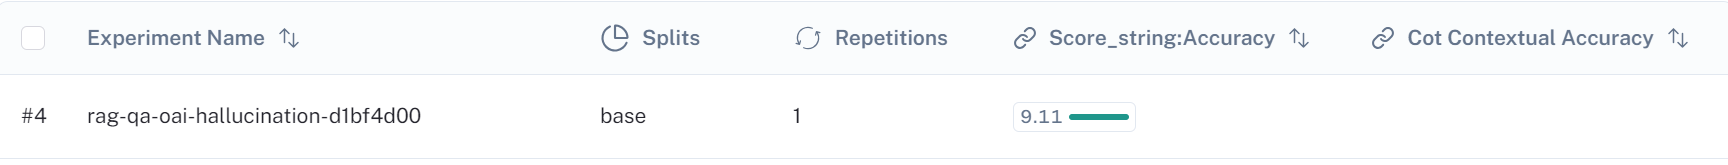

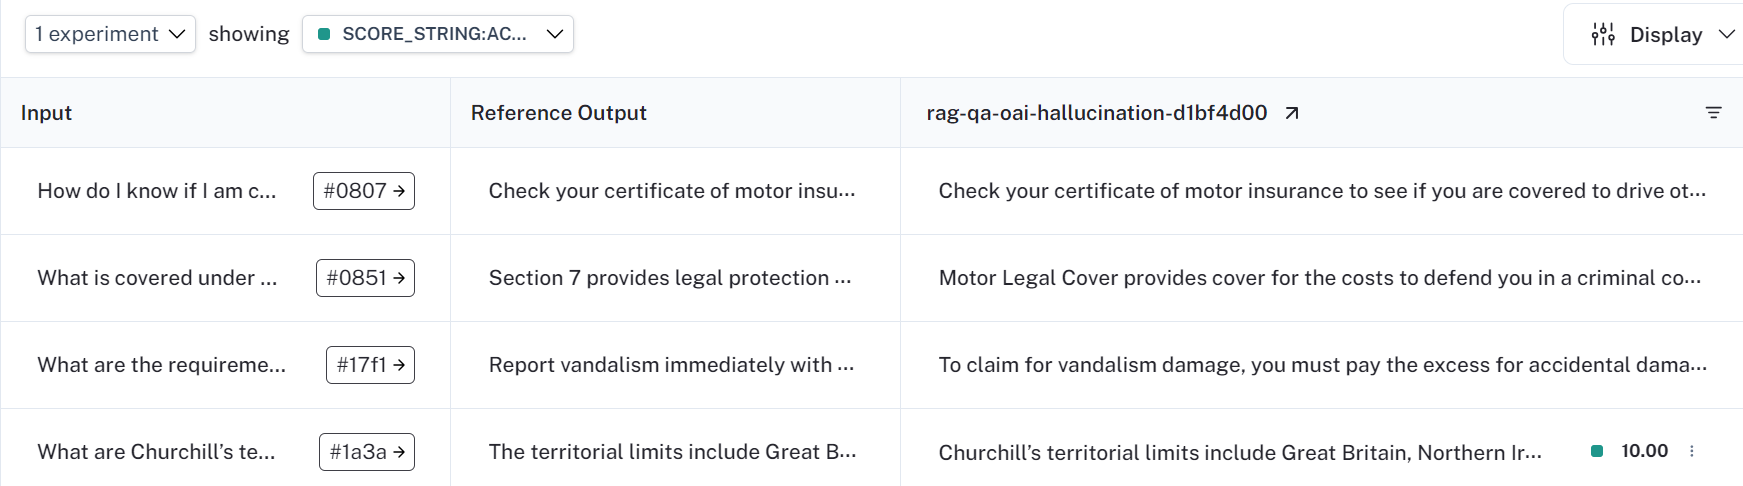
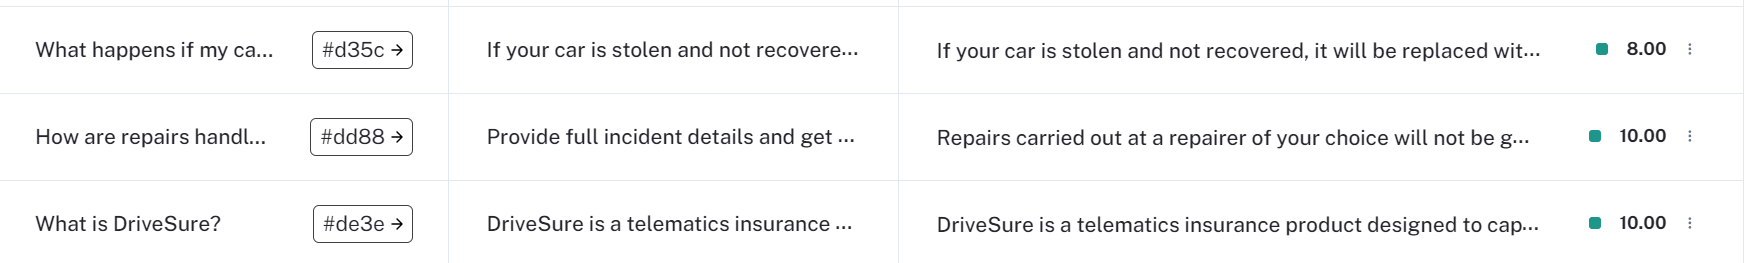